In [20]:
import pandas as pd
import os

input_data = 'model_collocated_10d_filled/'

import pickle 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import json 
import matplotlib.pyplot as plt
from keras.models import load_model

model = load_model('model-3.keras')

date = '20221029'

def load_data_from_feather(daily_ds):
    if isinstance(daily_ds, bytes):
        daily_ds = daily_ds.decode('utf-8')    
    df = pd.read_feather('model_collocated_10d_filled/'+daily_ds)
    asal_height_cols = [col for col in df.columns if col.startswith('ASAL_height')]
    ctemp_height_cols = [col for col in df.columns if col.startswith('CTEMP_height')]
    
    other_vars = ['LATITUDE', 'LONGITUDE', 'SSS', 'SST', 'SSH', 'MLD', 'UO', 'VO']
    
    new_df = df[other_vars]
    
    height_dfs = []
    for asal_col, ctemp_col in zip(asal_height_cols, ctemp_height_cols):
        height_df = new_df.copy()
        height_df['HEIGHT'] = asal_col.split('_height')[-1]
        height_df['ASAL'] = df[asal_col]  
        height_df['CTEMP'] = df[ctemp_col] 
        height_dfs.append(height_df)
    
    final_df = pd.concat(height_dfs, ignore_index=True)
    final_df = final_df.dropna()
    final_df = final_df[final_df['LATITUDE'] >= -60]
    final_df = final_df[final_df['LATITUDE'] <= 60]
    
    pivot_table = final_df.pivot_table(index=['LATITUDE', 'LONGITUDE', 'HEIGHT'], values=['SSS', 'SST', 'SSH', 'MLD', 'UO', 'VO', 'ASAL', 'CTEMP'])

    filename = os.path.basename(daily_ds)
    date_str = filename.split('.')[0]  
    date = pd.to_datetime(date_str, format='%Y%m%d')
    day_of_year = date.dayofyear

    pivot_table['DATE'] = day_of_year
    pivot_table = pivot_table.reset_index()
    pivot_table = pivot_table.astype(float)
    pivot_table = pivot_table[['LATITUDE', 'LONGITUDE', 'HEIGHT', 'SSS', 'SST', 'SSH', 'MLD', 'UO', 'VO', 'DATE', 'ASAL', 'CTEMP']]

    groups = pivot_table.groupby(['LATITUDE', 'LONGITUDE'])
    
    arrays = []
    
    n_row = 46
    
    with open('min_max_values.json', 'r') as f:
        min_max_values = json.load(f)
        
    for name, group in groups:
        if len(group) == n_row:
            group_sorted = group.sort_values(by='HEIGHT')
            for column in min_max_values['min_values'].keys():
                min_value = min_max_values['min_values'][column]
                max_value = min_max_values['max_values'][column]
                group_sorted[column] = (group_sorted[column] - min_value) / (max_value - min_value)

            array = group_sorted.values
            if (np.any(array)):
                arrays.append(array)
    
    arr_all = np.stack(arrays)
    X = arr_all[:,:,0:10]
    y = arr_all[:,:,10:12]
    return X, y


profiles, expected = load_data_from_feather(f'{date}.feather')

with open('min_max_values.json', 'r') as f:
    min_max_values = json.load(f)

p = model.predict(profiles)
asal_p1 = p[:,:,0] * (min_max_values['max_values']['ASAL'] - min_max_values['min_values']['ASAL']) + min_max_values['min_values']['ASAL']
ctemp_p1 = p[:,:,1] * (min_max_values['max_values']['CTEMP'] - min_max_values['min_values']['CTEMP']) + min_max_values['min_values']['CTEMP']
    
lats = profiles[:,0,0] * (min_max_values['max_values']['LATITUDE'] - min_max_values['min_values']['LATITUDE']) + min_max_values['min_values']['LATITUDE']
lons = profiles[:,0,1] * (min_max_values['max_values']['LONGITUDE'] - min_max_values['min_values']['LONGITUDE']) + min_max_values['min_values']['LONGITUDE']

asal = expected[:,:,0] * (min_max_values['max_values']['ASAL'] - min_max_values['min_values']['ASAL']) + min_max_values['min_values']['ASAL']
ctemp = expected[:,:,1] * (min_max_values['max_values']['CTEMP'] - min_max_values['min_values']['CTEMP']) + min_max_values['min_values']['CTEMP']
  

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


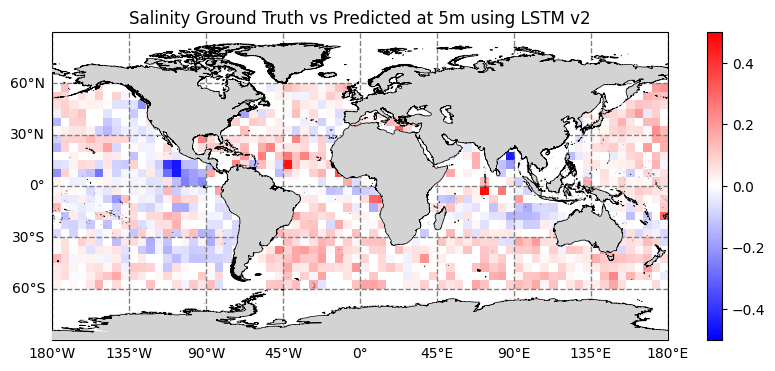

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, asal[:,4] - asal_p1[:,4], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-0.5, vmax=0.5)

plt.title('Salinity Ground Truth vs Predicted at 5m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_asal_5m.png')
plt.show()


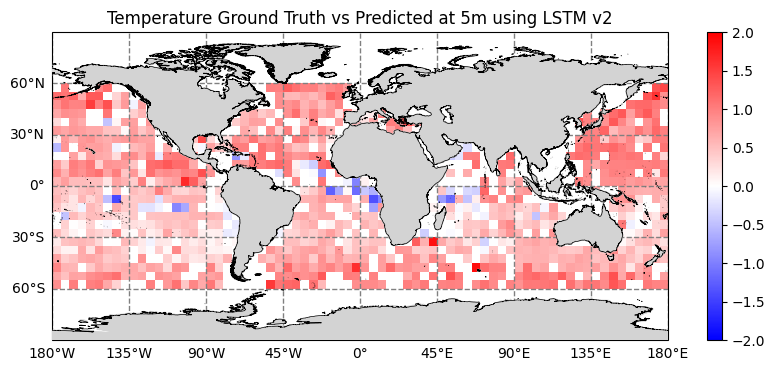

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, ctemp[:,4] - ctemp_p1[:,4], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-2, vmax=2)

plt.title('Temperature Ground Truth vs Predicted at 5m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_ctemp_5m.png')
plt.show()


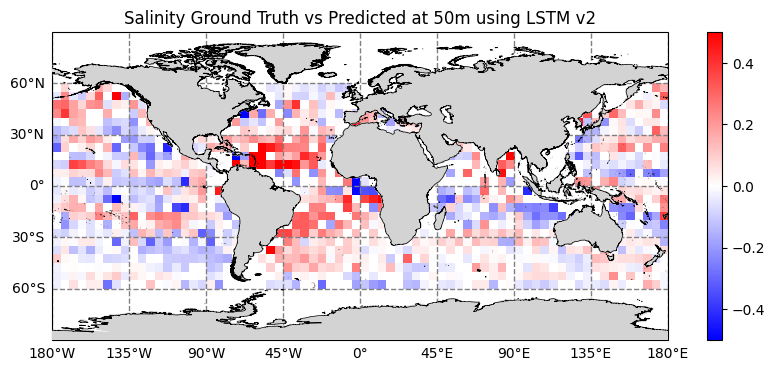

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, asal[:,17] - asal_p1[:,17], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-0.5, vmax=0.5)

plt.title('Salinity Ground Truth vs Predicted at 50m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_asal_50m.png')
plt.show()



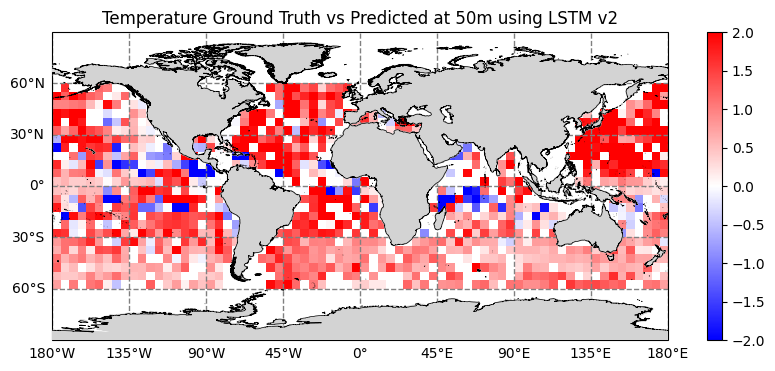

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, ctemp[:,17] - ctemp_p1[:,17], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-2, vmax=2)

plt.title('Temperature Ground Truth vs Predicted at 50m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_ctemp_50m.png')
plt.show()

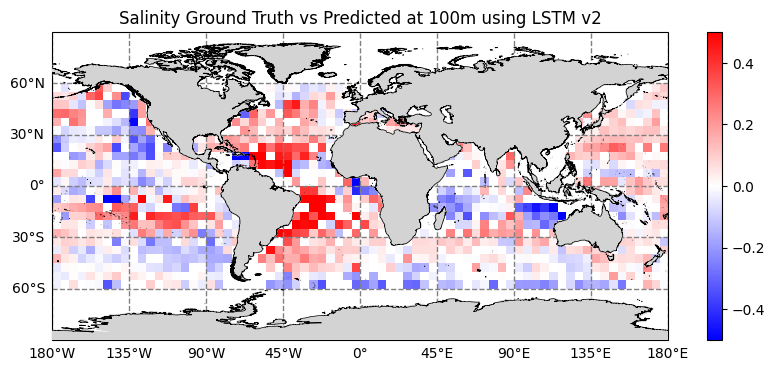

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, asal[:,23] - asal_p1[:,23], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-0.5, vmax=0.5)

plt.title('Salinity Ground Truth vs Predicted at 100m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_asal_100m.png')
plt.show()



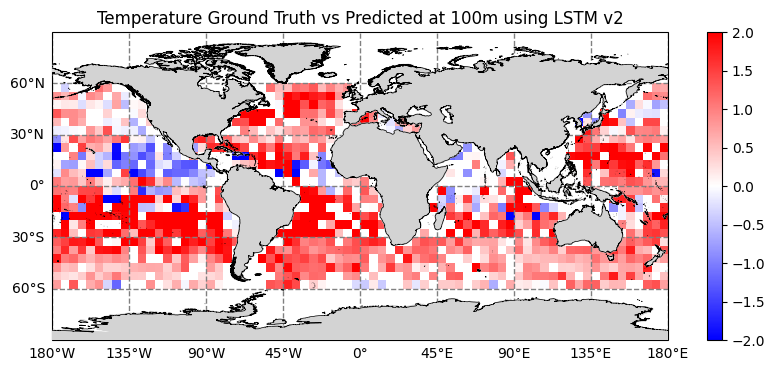

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, ctemp[:,23] - ctemp_p1[:,23], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-2, vmax=2)

plt.title('Temperature Ground Truth vs Predicted at 100m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_ctemp_100m.png')
plt.show()



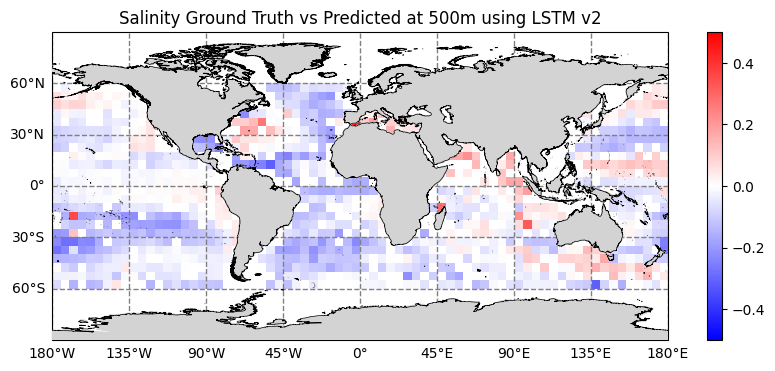

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, asal[:,39] - asal_p1[:,39], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-0.5, vmax=0.5)

plt.title('Salinity Ground Truth vs Predicted at 500m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_asal_500m.png')
plt.show()


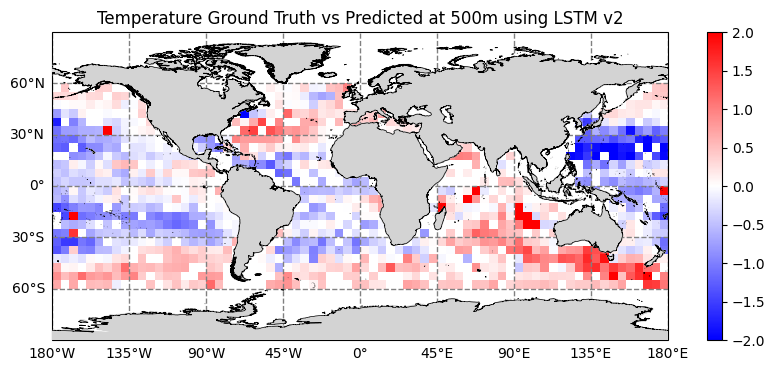

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

bin_means_p1, xedges, yedges, _ = binned_statistic_2d(lons, lats, ctemp[:,39] - ctemp_p1[:,39], statistic='mean', bins=[np.arange(-180, 181, 5), np.arange(-90, 91, 5)])

# Step 2: Plot the data using hist2d
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5, zorder=4)
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black', zorder=3)
plt.imshow(bin_means_p1.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='bwr', vmin=-2, vmax=2)

plt.title('Temperature Ground Truth vs Predicted at 500m using LSTM v2')
plt.colorbar()

# Set ticks for latitude and longitude axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 45))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 30))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.savefig('profs_model-3_ctemp_500m.png')
plt.show()

